## Классификация RUL различными методами

TO DO:
- LogReg
- Random Forest
- Naive Bayes (?)
- Gradient Boosting (sklearn, xgboost, catboost)
- LSTM
- CNN 
    - реккурентные графики
    - Gramian Angular Fields
    - Markov Transition Fields 
    

### TO DO:
- отработать MTF картинки
- визуализировать фильтры слоев
- разобраться с LSTM
- начать остальные алгоритмы

### Вопросы:
- Что делать с фичами? Если мы используем лишь начальные для сверточной сети (+ удаляя константы), то использование стд, макс и мин в других наверно не норм


### Заметки:
- Возможно смогу сделать МТФ изображения
- Есть способ преобразования временных рядов в символьное представление SAX
- Shapelets


#### Импорт библиотек

In [175]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
import itertools
from time import time

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

from tensorflow import GradientTape
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings("ignore")

#### Чтение данных

In [2]:
df = pd.read_parquet('data/train_data.parquet')

In [3]:
test = pd.read_parquet('data/test_data.parquet')

Отшкалируем данные и удалим наны

In [28]:
# params = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#        's15', 's16', 's17', 's18', 's19', 's20', 's21']

params = ['setting1', 'setting2', 's2', 's3', 's4', 's7', 
          's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
          's20', 's21']

In [29]:
scaler = StandardScaler()
df[params] = scaler.fit_transform(df[params])

In [30]:
test[params] = scaler.fit_transform(test[params])

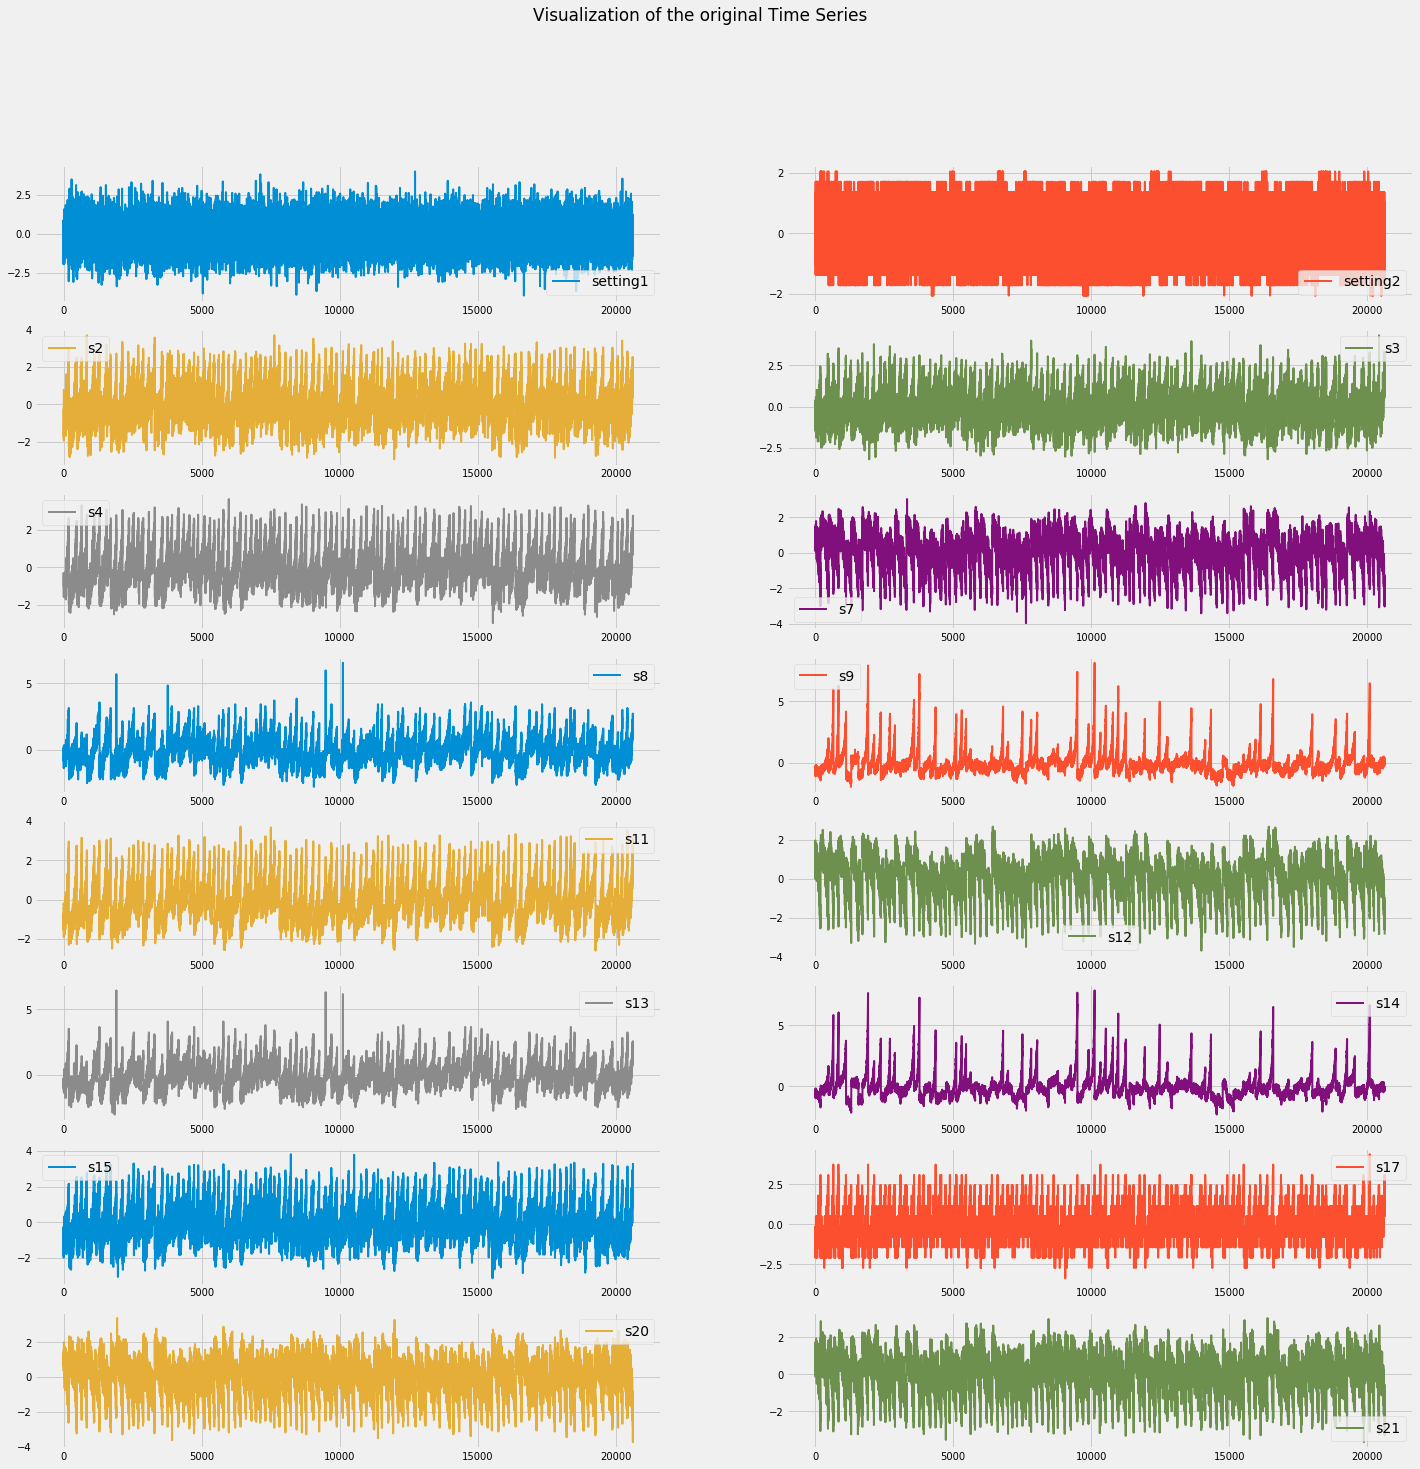

In [174]:
plt.style.use('fivethirtyeight')
df[params].plot(subplots=True,
        layout=(8, 2),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

#### Нейронные сети

Генерация последовательностей с окном 50

In [31]:
def seq_generator(data, seq_len, seq_cols):
    
    dt = data[seq_cols].values
    num_elem = dt.shape[0]
    for start, stop in zip(range(0, num_elem-seq_len), range(seq_len, num_elem)):
        yield df[start:stop, :]
        
def gen_labels(data, seq_len, label):
    
    dt = data[seq_cols].values
    num_elem = dt.shape[0]
    return dt[seq_len:num_elem, :]


In [32]:
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 (start stop) -> from row 0 to row 50
    # 1 51 (start stop) -> from row 1 to row 51
    # 2 52 (start stop) -> from row 2 to row 52
    # ...
    # 141 191 (start stop) -> from row 141 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [192]:
xtrain, xtest = [], []

seq_len = 50

for eid in df.id.unique():
    for seq in gen_sequence(df[df.id==eid], seq_len, params):
        xtrain.append(seq)
    for seq in gen_sequence(test[test.id==eid], seq_len, params):
        xtest.append(seq)
        
xtrain = np.asarray(xtrain)
xtest = np.asarray(xtest)

print('Xtrain shape: {},\nXtest shape: {}'.format(xtrain.shape, xtest.shape))

Xtrain shape: (15631, 50, 16),
Xtest shape: (8162, 50, 16)


In [193]:
ytrain, ytest = [],[]

for eid in df.id.unique():
    for label in gen_labels(df[df.id==eid], seq_len, ['label']):
        ytrain.append(label)
    for label in gen_labels(test[test.id==eid], seq_len, ['label']):
        ytest.append(label)
        
ytrain = np.asarray(ytrain).reshape(-1,1)
ytest = np.asarray(ytest).reshape(-1,1)

print('Ytrain shape: {},\nYtest shape: {}'.format(ytrain.shape, ytest.shape))

Ytrain shape: (15631, 1),
Ytest shape: (8162, 1)


In [195]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)


print('Ytrain shape: {},\nYtest shape: {}'.format(ytrain.shape, ytest.shape))

Ytrain shape: (15631, 3),
Ytest shape: (8162, 3)


#### Рекуррентные нейронные сети 

In [200]:
LAYERS = [8, 8, 8, 3]                # number of units in hidden and output layers

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(seq_len, len(params)), 
               units=LAYERS[0],
               activation='tanh', 
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(3e-2), 
               recurrent_regularizer=l2(3e-2),
               return_sequences=True, return_state=False,
               stateful=False, unroll=False ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', 
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(3e-2), 
               recurrent_regularizer=l2(3e-2),
               return_sequences=True, return_state=False,
               stateful=False, unroll=False ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', 
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(3e-2), 
               recurrent_regularizer=l2(3e-2),
               return_sequences=False, return_state=False,
               stateful=False, unroll=False ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=0.01))
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 50, 8)             800       
_________________________________________________________________
batch_normalization_18 (Batc (None, 50, 8)             32        
_________________________________________________________________
lstm_24 (LSTM)               (None, 50, 8)             544       
_________________________________________________________________
batch_normalization_19 (Batc (None, 50, 8)             32        
_________________________________________________________________
lstm_25 (LSTM)               (None, 8)                 544       
_________________________________________________________________
batch_normalization_20 (Batc (None, 8)                 32        
_________________________________________________________________
dense_9 (Dense)              (None, 3)               

In [207]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation


In [208]:
BATCH_SIZE = 200
EPOCHS = 20

History = model.fit(xtrain, ytrain,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[lr_decay, early_stop])

Train on 12504 samples, validate on 3127 samples
Epoch 1/20
12504/12504 [==============================] - 8s 607us/sample - loss: 0.1031 - accuracy: 0.9622 - val_loss: 0.1294 - val_accuracy: 0.9510
Epoch 2/20
12504/12504 [==============================] - 7s 550us/sample - loss: 0.1045 - accuracy: 0.9608 - val_loss: 0.1332 - val_accuracy: 0.9514
Epoch 3/20
12504/12504 [==============================] - 7s 560us/sample - loss: 0.1044 - accuracy: 0.9616 - val_loss: 0.1241 - val_accuracy: 0.9531
Epoch 4/20
12504/12504 [==============================] - 7s 536us/sample - loss: 0.0994 - accuracy: 0.9645 - val_loss: 0.1266 - val_accuracy: 0.9519
Epoch 5/20
12504/12504 [==============================] - 7s 547us/sample - loss: 0.1001 - accuracy: 0.9640 - val_loss: 0.1293 - val_accuracy: 0.9525
Epoch 6/20
12504/12504 [==============================] - 7s 560us/sample - loss: 0.1006 - accuracy: 0.9629 - val_loss: 0.1274 - val_accuracy: 0.9530
Epoch 7/20
12504/12504 [===========================

In [209]:
# Evaluate the model:
model.evaluate(xtest, ytest, verbose=0)[1]

0.87862444

In [210]:
print(classification_report(np.where(ytest != 0)[1], model.predict_classes(xtest)))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      6922
           1       0.42      0.67      0.52      1180
           2       0.13      1.00      0.24        60

    accuracy                           0.82      8162
   macro avg       0.52      0.84      0.55      8162
weighted avg       0.91      0.82      0.85      8162



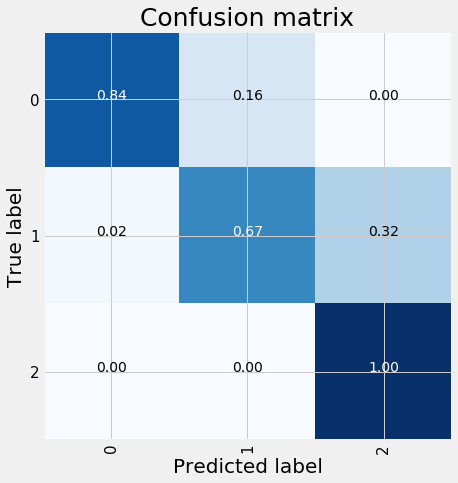

In [211]:
cnf_matrix = confusion_matrix(np.where(ytest != 0)[1], model.predict_classes(xtest))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(ytest != 0)[1]), title="Confusion matrix")
plt.show()

#### Генерация изображений

Рекуррентные графики

In [36]:
def recurrent_plots(series, eps=0.1, steps=10):
    dists = pdist(series[:,None])
    dists = np.floor(dists/eps)
    
    dists[dists > steps] = steps
    pic = squareform(dists)
    return pic

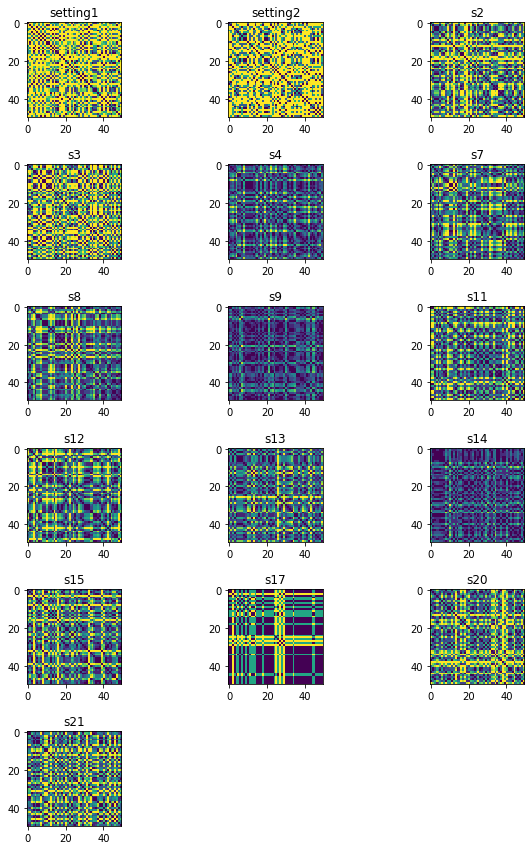

In [37]:
plt.figure(figsize=(10,20))

for i in range(len(params)):

    plt.subplot(8,3,i+1)
    rec = recurrent_plots(xtrain[0,:,i])
    
#     im = Image.fromarray(rec)
#     im.save('pics/rec_plot/'+params[i]+'.png')
    
    plt.imshow(rec)
    plt.title(params[i])
    
plt.subplots_adjust(wspace=0.3,hspace=0.5)
plt.show()

In [38]:
xtrain_img = np.apply_along_axis(recurrent_plots, 1, xtrain).astype('float32')
xtest_img = np.apply_along_axis(recurrent_plots, 1, xtest).astype('float32')

print(xtrain_img.shape, xtest_img.shape)

(15631, 50, 50, 16) (8162, 50, 50, 16)


#### Сверточные нейронные сети

Моделирование

In [106]:
# path = 'CNN_RUL_rec.hdf5'

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(50,50,len(params)), name='layer_conv1'))
model.add(Conv2D(32, (3, 3), activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool1'))
model.add(Dropout(0.25, name='drop1'))

model.add(Conv2D(64, (3,3), activation='relu', name='layer_conv3'))
model.add(Conv2D(64, (3,3), activation='relu', name='layer_conv4'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool2'))
model.add(Dropout(0.25, name='drop2'))

model.add(Flatten(name='flat1'))
model.add(Dense(256, activation='relu', name='dense1'))
model.add(Dropout(0.5, name='drop3'))
model.add(Dense(3, activation='softmax', name='dense2'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

W0226 23:48:06.192734 19580 deprecation.py:506] From C:\Users\I519322\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 48, 48, 32)        4640      
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 23, 23, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 23, 23, 32)        0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 21, 21, 64)        18496     
_________________________________________________________________
layer_conv4 (Conv2D)         (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 9, 9, 64)         

In [48]:
BATCH_SIZE = 200
EPOCHS = 20

history = model.fit(xtrain_img,
                   ytrain,
                   batch_size=BATCH_SIZE, 
                   epochs=EPOCHS,
                   validation_split=0.2,
                   verbose=1)

Train on 12504 samples, validate on 3127 samples
Epoch 1/20
12504/12504 [==============================] - 86s 7ms/sample - loss: 0.1149 - acc: 0.9569 - val_loss: 0.4505 - val_acc: 0.8388
Epoch 2/20
12504/12504 [==============================] - 90s 7ms/sample - loss: 0.1002 - acc: 0.9601 - val_loss: 0.5068 - val_acc: 0.8382
Epoch 3/20
12504/12504 [==============================] - 91s 7ms/sample - loss: 0.0889 - acc: 0.9678 - val_loss: 0.5583 - val_acc: 0.8462
Epoch 4/20
12504/12504 [==============================] - 90s 7ms/sample - loss: 0.0830 - acc: 0.9702 - val_loss: 0.5052 - val_acc: 0.8388
Epoch 5/20
12504/12504 [==============================] - 88s 7ms/sample - loss: 0.0691 - acc: 0.9732 - val_loss: 0.5663 - val_acc: 0.8487
Epoch 6/20
12504/12504 [==============================] - 88s 7ms/sample - loss: 0.0741 - acc: 0.9724 - val_loss: 0.5178 - val_acc: 0.8484
Epoch 7/20
12504/12504 [==============================] - 89s 7ms/sample - loss: 0.0648 - acc: 0.9754 - val_loss: 0.6

In [49]:
model.evaluate(xtest_img, ytest, verbose=0)[1]

0.8719677

In [50]:
print(classification_report(np.where(ytest != 0)[1], model.predict_classes(xtest_img)))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      6922
           1       0.54      0.72      0.62      1180
           2       0.32      0.72      0.44        60

    accuracy                           0.87      8162
   macro avg       0.61      0.78      0.66      8162
weighted avg       0.90      0.87      0.88      8162



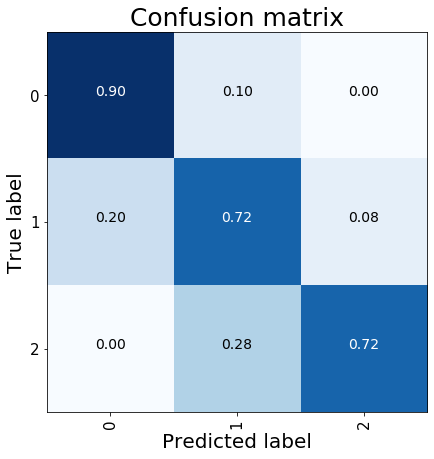

In [51]:
cnf_matrix = confusion_matrix(np.where(ytest != 0)[1], model.predict_classes(xtest_img))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(ytest != 0)[1]), title="Confusion matrix")
plt.show()

Gramian Angular Field

In [60]:
def tabulate(x, y, f):
    """Return a table of f(x, y). Useful for the Gram-like operations."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))

def cos_sum(a, b):
    """To work with tabulate."""
    return(math.cos(a+b))

def create_time_serie(size, time):
    """Generate a time serie of length size and dynamic with respect to time."""
    # Generating time-series
    support = np.arange(0, size)
    serie = np.cos(support + float(time))
    return(t, serie)

In [65]:
class GAF:

    def __init__(self):
        pass
    def transform(self, serie):
        """Compute the Gramian Angular Field of an image"""
        # Min-Max scaling
#         min_ = np.amin(serie)
#         max_ = np.amax(serie)
#         scaled_serie = (2*serie - max_ - min_)/(max_ - min_)

        # Floating point inaccuracy!
        serie = np.where(serie >= 1., 1., serie)
        serie = np.where(serie <= -1., -1., serie)

        # Polar encoding
        phi = np.arccos(serie)
        # Note! The computation of r is not necessary
        r = np.linspace(0, 1, len(serie))

        # GAF Computation (every term of the matrix)
        gaf = tabulate(phi, phi, cos_sum)

        #return(gaf, phi, r, scaled_serie)
        return gaf

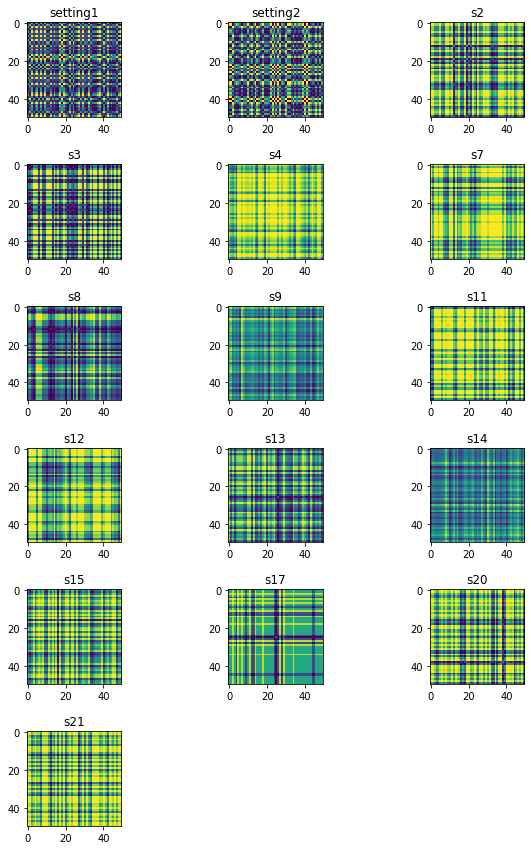

In [66]:
plt.figure(figsize=(10,20))

gaf = GAF()

for i in range(len(params)):

    plt.subplot(8,3,i+1)
    #pic,_,_,_ = gaf.transform(xtrain[0,:,i])
    pic = gaf.transform(xtrain[0,:,i])
    plt.imshow(pic)
    plt.title(params[i])
    
plt.subplots_adjust(wspace=0.3,hspace=0.5)
plt.show()

In [67]:
xtrain_img = np.apply_along_axis(gaf.transform, 1, xtrain).astype('float32')
xtest_img = np.apply_along_axis(gaf.transform, 1, xtest).astype('float32')

print(xtrain_img.shape, xtest_img.shape)

(15631, 50, 50, 16) (8162, 50, 50, 16)


In [69]:
np.save('data/xtrain_img_gaf.npy', xtrain_img)
np.save('data/xtest_img_gaf.npy', xtest_img)

.npy extension is added if not given


np.load('test3.npy')

In [107]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 48, 48, 32)        4640      
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 23, 23, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 23, 23, 32)        0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 21, 21, 64)        18496     
_________________________________________________________________
layer_conv4 (Conv2D)         (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 9, 9, 64)         

In [70]:
BATCH_SIZE = 200
EPOCHS = 10

history = model.fit(xtrain_img,
                   ytrain,
                   batch_size=BATCH_SIZE, 
                   epochs=EPOCHS,
                   validation_split=0.2,
                   verbose=1)

Train on 12504 samples, validate on 3127 samples
Epoch 1/10
12504/12504 [==============================] - 90s 7ms/sample - loss: 0.9971 - acc: 0.6647 - val_loss: 0.5679 - val_acc: 0.7880
Epoch 2/10
12504/12504 [==============================] - 92s 7ms/sample - loss: 0.5403 - acc: 0.7633 - val_loss: 0.5087 - val_acc: 0.8136
Epoch 3/10
12504/12504 [==============================] - 89s 7ms/sample - loss: 0.4984 - acc: 0.7829 - val_loss: 0.4885 - val_acc: 0.8324
Epoch 4/10
12504/12504 [==============================] - 90s 7ms/sample - loss: 0.4708 - acc: 0.7979 - val_loss: 0.4744 - val_acc: 0.8161
Epoch 5/10
12504/12504 [==============================] - 90s 7ms/sample - loss: 0.4526 - acc: 0.8029 - val_loss: 0.4459 - val_acc: 0.8212
Epoch 6/10
12504/12504 [==============================] - 90s 7ms/sample - loss: 0.4298 - acc: 0.8194 - val_loss: 0.4292 - val_acc: 0.8478
Epoch 7/10
12504/12504 [==============================] - 90s 7ms/sample - loss: 0.4179 - acc: 0.8238 - val_loss: 0.4

In [71]:
model.evaluate(xtest_img, ytest, verbose=0)[1]

0.8328841

In [72]:
print(classification_report(np.where(ytest != 0)[1], model.predict_classes(xtest_img)))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      6922
           1       0.44      0.48      0.46      1180
           2       0.15      0.93      0.25        60

    accuracy                           0.83      8162
   macro avg       0.51      0.77      0.55      8162
weighted avg       0.87      0.83      0.85      8162



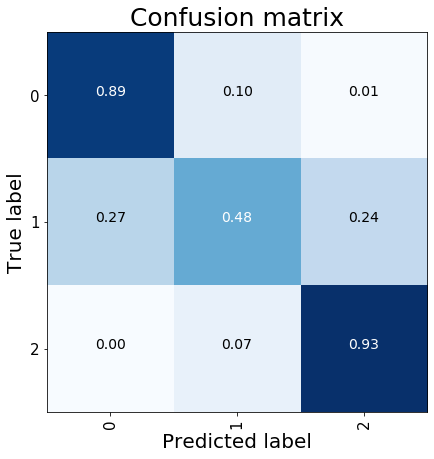

In [73]:
cnf_matrix = confusion_matrix(np.where(ytest != 0)[1], model.predict_classes(xtest_img))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(ytest != 0)[1]), title="Confusion matrix")
plt.show()

Визуализация фильтров

In [75]:
layer_variables = model.get_layer('conv2d_4').get_weights()

weights = layer_variables[0]
biases = layer_variables[1]

w = np.array(weights)
w.shape

(3, 3, 16, 32)

In [76]:
w = np.moveaxis(w, 2, 0)
w = np.moveaxis(w, 3, 0)
print(w.shape)

(32, 16, 3, 3)


In [77]:
w.shape[1]

16

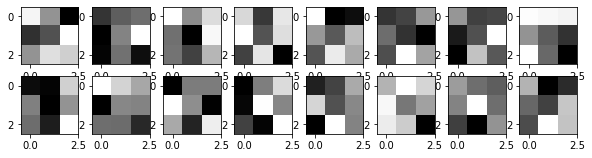

In [78]:


# the total filter in previous layers will be obtained from w.shape[1]
total_filters_in_prev_layers = 16

cols = 8
rows = 8
# rows * cols > total_filters

# current_filter = which filter's weights we want to see
current_filter = 10

fig = plt.figure(figsize=(10, 10))

for each_depth in range(w.shape[1]):
    fig.add_subplot(rows, cols, each_depth+1)
    plt.imshow(w[current_filter][each_depth], cmap='gray')

In [108]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(xtrain_img[10].reshape(1,50,50,len(params)))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

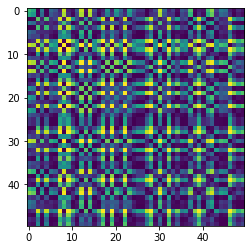

In [109]:
plt.imshow(xtrain_img[10][:,:,0])

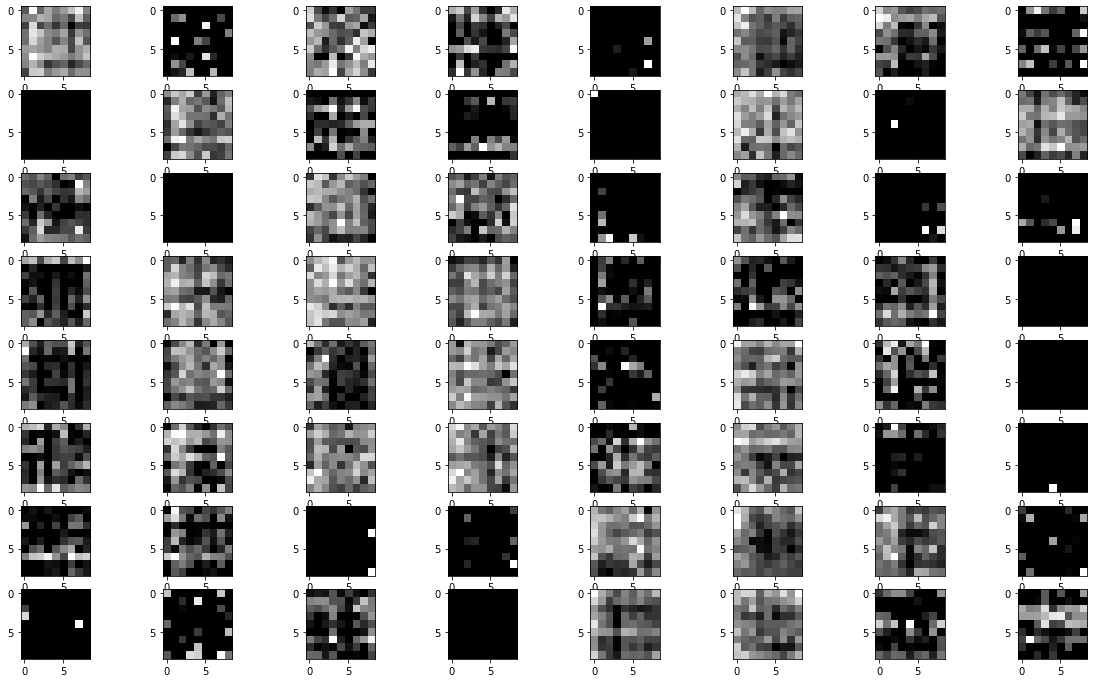

In [114]:
display_activation(activations, 8, 8, 6)

#### Приложение

In [46]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)